<a href="https://colab.research.google.com/github/cseeg/DiSCoVeR-SuperCon-NOMAD-SMACT/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **pips and imports**

In [2]:
%%time
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
print(f"torch version: {torch.__version__}")
!pip install -U pip
try:
  import mat_discover
except:
  !pip install -UI mat_discover

%pip install pymatgen
%pip install CBFV
%pip install SMACT

# **You must restart the runtime after this step**


torch version: 1.12.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 173 ms, sys: 120 ms, total: 294 ms
Wall time: 17.6 s


In [3]:
# imports
import pandas as pd
import numpy as np
import mat_discover
print(f"DiSCoVeR version {mat_discover.__version__}")
from mat_discover.mat_discover_ import Discover
from pymatgen.core.composition import Composition
import math
from os.path import join
from pathlib import Path
import crabnet
print(f"CrabNet version {crabnet.__version__}")
from CBFV import composition
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import smact
from smact.screening import pauling_test
import itertools
from fractions import Fraction
import functools

DiSCoVeR version 2.2.3
CrabNet version 2.0.7


In [4]:
#mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Read in and organize `train_df` and `val_df`**

In [5]:
# Read in data, delete unwanted columns

df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/supercon.csv")
train_df = df[(df[['target']] != 0).all(axis=1)]

val_df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/NOMAD-unique-reduced-formula.csv")

del val_df["calc_id"]
del val_df["count"]
val_df.rename(columns = {'reduced_formula':'formula'}, inplace=True)
val_df.drop(val_df.tail(1).index, inplace=True)
val_df.dropna()

display(train_df)
display(val_df)

,formula,target
0,Ba0.4K0.6Fe2As2,31.20
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10
2,Mo0.39Ru0.61,6.90
3,Tm4Os6Sn19,1.10
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.85
...,...,...
16374,La1.78Sr0.22Cu0.9975Zn0.0025O4,19.25
16376,Nb0.96Ta0.04,8.87
16377,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60
16378,Yb0.5Pr0.5Ba2Cu3O6.9,34.80


,formula
0,Ac
1,Ac(AgO2)2
2,Ac(AsO2)2
3,Ac(AuO2)2
4,Ac(BO2)2
...,...
695606,ZrZnW3
695607,ZrZnW4
695608,ZrZnWAu
695609,ZrZnWC


In [6]:
# Reducing the compositions in train_df using get_reduced_composition_and_factor() from pymatgen.core.composition

num_reduced_comps=[]
reduced_comps = []
for i in (train_df.loc[:,"formula"]):
  comp = Composition(i).get_reduced_formula_and_factor()
  reduced_comps.append(comp[0])
  if comp[1]>1:
    num_reduced_comps.append(comp[1])

print(f"There are {(len(num_reduced_comps))} reduced compositions")

train_df.loc[:,"formula"] = reduced_comps

display(train_df)

There are 220 reduced compositions


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,formula,target
0,K0.6Ba0.4Fe2As2,31.20
1,Ba1.25Ca0.4La1.25Cu3O6.98,40.10
2,Mo0.39Ru0.61,6.90
3,Tm4Sn19Os6,1.10
4,Nd1Bi0.99Pb0.01S2O0.7F0.3,4.85
...,...,...
16374,Sr0.22La1.78Zn0.0025Cu0.9975O4,19.25
16376,Ta0.04Nb0.96,8.87
16377,Sr2Ca0.5Ho0.5Al0.018Cu2.982Pb2O8,63.60
16378,Ba2Yb0.5Pr0.5Cu3O6.9,34.80


In [7]:
# remove rows corresponding to formulas in val_df that overlap with train_df
cond = val_df['formula'].isin(train_df['formula'])

val_df.drop(val_df[cond].index, inplace = True)

display(train_df)
display(val_df)

,formula,target
0,K0.6Ba0.4Fe2As2,31.20
1,Ba1.25Ca0.4La1.25Cu3O6.98,40.10
2,Mo0.39Ru0.61,6.90
3,Tm4Sn19Os6,1.10
4,Nd1Bi0.99Pb0.01S2O0.7F0.3,4.85
...,...,...
16374,Sr0.22La1.78Zn0.0025Cu0.9975O4,19.25
16376,Ta0.04Nb0.96,8.87
16377,Sr2Ca0.5Ho0.5Al0.018Cu2.982Pb2O8,63.60
16378,Ba2Yb0.5Pr0.5Cu3O6.9,34.80


,formula
0,Ac
1,Ac(AgO2)2
2,Ac(AsO2)2
3,Ac(AuO2)2
4,Ac(BO2)2
...,...
695606,ZrZnW3
695607,ZrZnW4
695608,ZrZnWAu
695609,ZrZnWC


In [8]:
# Drop NaNs in val_df and random formula named Zircaloy
val_df = val_df.dropna()
val_df = val_df[val_df["formula"].str.contains("Zircaloy") == False]
  

display(val_df)


,formula
0,Ac
1,Ac(AgO2)2
2,Ac(AsO2)2
3,Ac(AuO2)2
4,Ac(BO2)2
...,...
695606,ZrZnW3
695607,ZrZnW4
695608,ZrZnWAu
695609,ZrZnWC


#**Check validity of formulas in `train_df` and `val_df` using SMACT**

In [9]:
#define smact function

def smact_validity(comp, count,
                   use_pauling_test=True,
                   include_alloys=True):
    global compositions
    space = smact.element_dictionary(comp)
    smact_elems = [e[1] for e in space.items()]
    electronegs = [e.pauling_eneg for e in smact_elems]
    ox_combos = [e.oxidation_states for e in smact_elems]
    if len(set(comp)) == 1:
        return True
    if include_alloys:
        is_metal_list = [elem_s in smact.metals for elem_s in comp]
        if all(is_metal_list):
            return True

    threshold = np.max(count)
    compositions = []
    for ox_states in itertools.product(*ox_combos):
        stoichs = [(c,) for c in count]
        # Test for charge balance
        cn_e, cn_r = smact.neutral_ratios(
            ox_states, stoichs=stoichs, threshold=threshold)
        # Electronegativity test
        if cn_e:
            if use_pauling_test:
                try:
                    electroneg_OK = pauling_test(ox_states, electronegs)
                except TypeError:
                    # if no electronegativity data, assume it is okay
                    electroneg_OK = True
            else:
                electroneg_OK = True
            if electroneg_OK:
                for ratio in cn_r:
                    compositions.append(
                        tuple([comp, ox_states, ratio]))
    compositions = [(i[0], i[2]) for i in compositions]
    compositions = list(set(compositions))
    if len(compositions) > 0:
        return True
    else:
        return False


**First with `train_df`**

*   Formulas with floats for subscripts are computed into whole integers ex. `'Ta0.25Nb0.75'` is changed to `Ta1Nb3`



In [10]:
vals2 = []
for i in train_df['formula']:
  form_dict = Composition(i).to_reduced_dict

  comp = tuple(form_dict.keys())

  count = list(form_dict.values())

  #find least common multiple to get count as a tuple of ints
  denom_list = [(Fraction(x).limit_denominator()).denominator for x in count]
  lcm = functools.reduce(lambda a,b: a*b//math.gcd(a,b), denom_list)

  count_list= []
  for i in count:
    count_list.append(int(i*lcm))

  count = tuple(count_list)
  
  #vals2 is a list of Boolean corresponding to each formula's validity
  vals2.append(smact_validity(comp, count))

In [11]:
### 6730/12415 formulas are valid (54%)
### append Boolean vals to train_df

train_df['is_valid'] = vals2
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,formula,target,is_valid
0,K0.6Ba0.4Fe2As2,31.20,False
1,Ba1.25Ca0.4La1.25Cu3O6.98,40.10,False
2,Mo0.39Ru0.61,6.90,True
3,Tm4Sn19Os6,1.10,True
4,Nd1Bi0.99Pb0.01S2O0.7F0.3,4.85,False
...,...,...,...
16374,Sr0.22La1.78Zn0.0025Cu0.9975O4,19.25,False
16376,Ta0.04Nb0.96,8.87,True
16377,Sr2Ca0.5Ho0.5Al0.018Cu2.982Pb2O8,63.60,True
16378,Ba2Yb0.5Pr0.5Cu3O6.9,34.80,False


**Then with `val_df`**

*   Subscripts are already whole numbers
*   Takes ~15 minutes running on a GPU since there are a lot of formulas

In [ ]:
vals = []
for i in val_df['formula']:
  form_dict = Composition(i).to_reduced_dict

  comp = tuple(form_dict.keys())

  lyst = list(form_dict.values())
  lyst = [int(x) for x in lyst]
  count = tuple(lyst)

  vals.append(smact_validity(comp, count))



In [ ]:
### 544383/694398 formulas are valid (78.3964%)
### append Boolean vals to val_df

val_df['is_valid'] = vals
val_df

#**Train dummy model and DiSCoVeR model**

**First set up and test on a dummy regressor (using mat2vec as the CBFV) and calculate error metrics**


In [ ]:
X,y,formulae,skipped=composition.generate_features(train_df,elem_prop='mat2vec')

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
y_pred = dummy_regr.predict(X)

print(f"MAE on Dummy Regressor: {mean_absolute_error(y, y_pred)}")
# print(f"MSE on Dummy Regressor: {mean_squared_error(y, y_pred)}")
# print(f"R squared on Dummy Regressor: {r2_score(y, y_pred)}")



Processing Input Data: 100%|██████████| 12415/12415 [00:00<00:00, 14187.67it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 12415/12415 [00:02<00:00, 5952.03it/s]


	Creating Pandas Objects...
MAE on Dummy Regressor: 22.665175674489305


**Next set up DiSCoVeR model**

In [ ]:
# initialize DiSCoVeR model

disc = Discover(hdbscan_kwargs=dict(min_samples=1, min_cluster_size=225), use_plotly_offline=False, target_unit="Tc", dist_device="cuda")
# disc = Discover(hdbscan_kwargs=dict(min_samples=1, min_cluster_size=256), use_plotly_offline=False, target_unit="Tc", dist_device="cpu")

In [ ]:
#shuffle data

train_df = train_df.sample(frac=1)

val_df = val_df.sample(frac=1)

display(train_df)
display(val_df)

,formula,target,is_valid
9573,Nb0.86Rh1.04,3.76,True
3127,Mg0.9Zn0.1Ni3C1,4.50,True
13657,Zr0.5Nb3In0.5,6.40,True
5417,Sm1Fe0.92Ni0.08As1O1,6.00,True
1897,Hf0.261V2.739Ga1,6.40,True
...,...,...,...
15814,La0.999Gd0.001Al2,2.78,True
6857,Rb2Na1H2.58C60N0.86,12.00,False
7135,MgHg3,0.48,True
1156,Sr2Ce0.7Eu1.3Cu2Ru1O10,33.00,True


,formula,is_valid
375381,MgCoReW,True
690863,ZrSc4Ir,True
186475,Ga4As,False
663205,Zn3Ga9O,False
467969,PH14(C3S)2,True
...,...,...
305829,La2SmCr,True
578490,TaMnPt2,True
1049,AcEr2Re,True
133188,Cr4CdRe,True


**Fit training data on DiSCoVeR**

In [ ]:
disc.fit(train_df)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 9932/9932 [00:00<00:00, 103280.88formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 512 (2**9.000)


Generating EDM: 100%|██████████| 2483/2483 [00:00<00:00, 91402.99formulae/s]

loading data with up to 8 elements in the formula
stepping every 200 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 20 val mae: 20
Epoch: 19/300 --- train mae: 4.94 val mae: 5.38
Epoch: 39/300 --- train mae: 3.23 val mae: 4.52
Epoch: 59/300 --- train mae: 2.41 val mae: 4.26
Epoch: 79/300 --- train mae: 2 val mae: 4.16
Epoch: 99/300 --- train mae: 1.74 val mae: 4.09
Epoch: 119/300 --- train mae: 1.58 val mae: 4.05
Epoch: 139/300 --- train mae: 1.48 val mae: 4
Epoch: 159/300 --- train mae: 1.39 val mae: 3.99
Epoch: 179/300 --- train mae: 1.33 val mae: 3.99
Epoch: 199/300 --- train mae: 1.29 val mae: 3.97
Epoch: 219/300 --- train mae: 1.25 val mae: 3.99
Epoch 239 failed to improve.
Discarded: 1/3 weight updates
Epoch: 239/300 --- train mae: 1.22 val mae: 4.01
Epoch 259 failed to improve.
Discarded: 2/3 weight updates
Epoch: 259/300 --- train mae: 1.2 val mae: 4.03
Epoch 279 failed to improve.
Discarded: 3/3 weight updates
Epoch: 279/300 --- train mae: 1.17 val mae: 4.03
Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models/trained_models/Un

**Predict val_df in chunks**

In [1]:
#Predict through val_df in chunks (chunks are split to match 70/30 Training/Validation data)
#There are 70 chunks each with ~10,000 compositions

dens_score = []
peak_score = []

val_dfs = np.array_split(val_df, 70)
# print((val_dfs[0]))

jd = 0
for i, val_df in enumerate(val_dfs):
    jd = jd + 1
    disc.predict(val_df, umap_random_state=42)
    dens_score.append(disc.dens_score_df.sample(frac=1))
    peak_score.append(disc.peak_score_df.sample(frac=1))
    print(f"\nDone with iteration {jd}\n")

NameError: ignored

In [ ]:
# Organize list of DataFrames and sort by score

dens_score_df = pd.DataFrame()
peak_score_df = pd.DataFrame()

for i in dens_score:
  dens_score_df = dens_score_df.append(i, ignore_index=True)

dens_score_df.sort_values('score',inplace=True,ascending=False)

for j in peak_score:
  peak_score_df = peak_score_df.append(j, ignore_index=True)

peak_score_df.sort_values('score',inplace=True,ascending=False)

display(dens_score_df.head(25))
print("")
display(peak_score_df.head(25))

,formula,prediction,density,score,index
600059,CaCu4Sb,150.656235,3.385642,29.250681,90066
253958,CaAl2O12,132.798248,6.247991,25.816469,86453
440941,Ca(NO5)2,135.998795,6.453689,25.167288,79500
155065,YCu13,125.323814,6.211921,25.133519,643624
660206,Ca(IO6)2,134.643600,6.899210,24.973459,79435
551415,Ba2CaTl,126.584602,2.402361,24.831666,29774
628223,BaMg8,128.096863,5.390813,24.815515,48983
324453,CaSbPb4,129.982697,12.087344,24.587870,99503
672820,YCu8,133.906372,4.373719,24.431935,643729
517842,Ba2Mg17,122.497086,2.257852,23.672225,30981


,formula,prediction,density,score,index
598371,CaCu4Sb,150.656235,3.385642,47.052665,90066
674416,YCu8,133.906372,4.373719,41.937544,643729
154411,YCu13,125.323814,6.211921,40.821976,643624
627617,BaMg8,128.096863,5.390813,40.673097,48983
325169,CaSbPb4,129.982697,12.087344,40.564527,99503
248074,CaAl2O12,132.798248,6.247991,40.036386,86453
522996,Ba2Mg17,122.497086,2.257852,39.019987,30981
441143,Ca(NO5)2,135.998795,6.453689,38.465214,79500
550389,Ba2CaTl,126.584602,2.402361,37.183831,29774
282759,BaY7,119.311790,2.756119,36.999765,60262


**Append the Boolean values to each dataframe and then resort by score**

In [ ]:
dens_score_df = dens_score_df.sort_values(by='index')
dens_score_df['is_valid'] = val_df['is_valid']
dens_score_df = dens_score_df.sort_values(by='score', ascending=False)


peak_score_df = peak_score_df.sort_values(by='index')
peak_score_df['is_valid'] = val_df['is_valid']
peak_score_df = peak_score_df.sort_values(by='score', ascending=False)

In [ ]:
dsdf = dens_score_df.drop(['index'], axis=1)

KeyError: ignored

In [ ]:
psdf = peak_score_df.drop(['index'], axis=1)

,formula,prediction,density,score,is_valid
600059,CaCu4Sb,150.656235,3.385642,29.250681,True
253958,CaAl2O12,132.798248,6.247991,25.816469,True
440941,Ca(NO5)2,135.998795,6.453689,25.167288,False
155065,YCu13,125.323814,6.211921,25.133519,True
660206,Ca(IO6)2,134.643600,6.899210,24.973459,True
...,...,...,...,...,...
17929,Na3SiPt,7.122471,0.889169,0.883617,False
174057,HgH10C12Br2(N2O)2,7.033318,1.352084,0.883612,True
34789,Ba3CaP,6.837135,1.043855,0.883596,True
439172,MgB2Pt,12.045229,16.268454,0.883594,True


**Import/Export files for future use**

In [ ]:
#export dens_score and peak_score as csv files

dsdf.to_csv(r"/content/drive/MyDrive/ReUSE/CDVAE-Discover/dens_score.csv", index = False)

psdf.to_csv(r"/content/drive/MyDrive/ReUSE/CDVAE-Discover/peak_score.csv", index = False)

NameError: ignored

In [ ]:
#import files if needed

dens_score_df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/dens_score.csv")
peak_score_df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/peak_score.csv")

#**Visualizing data**

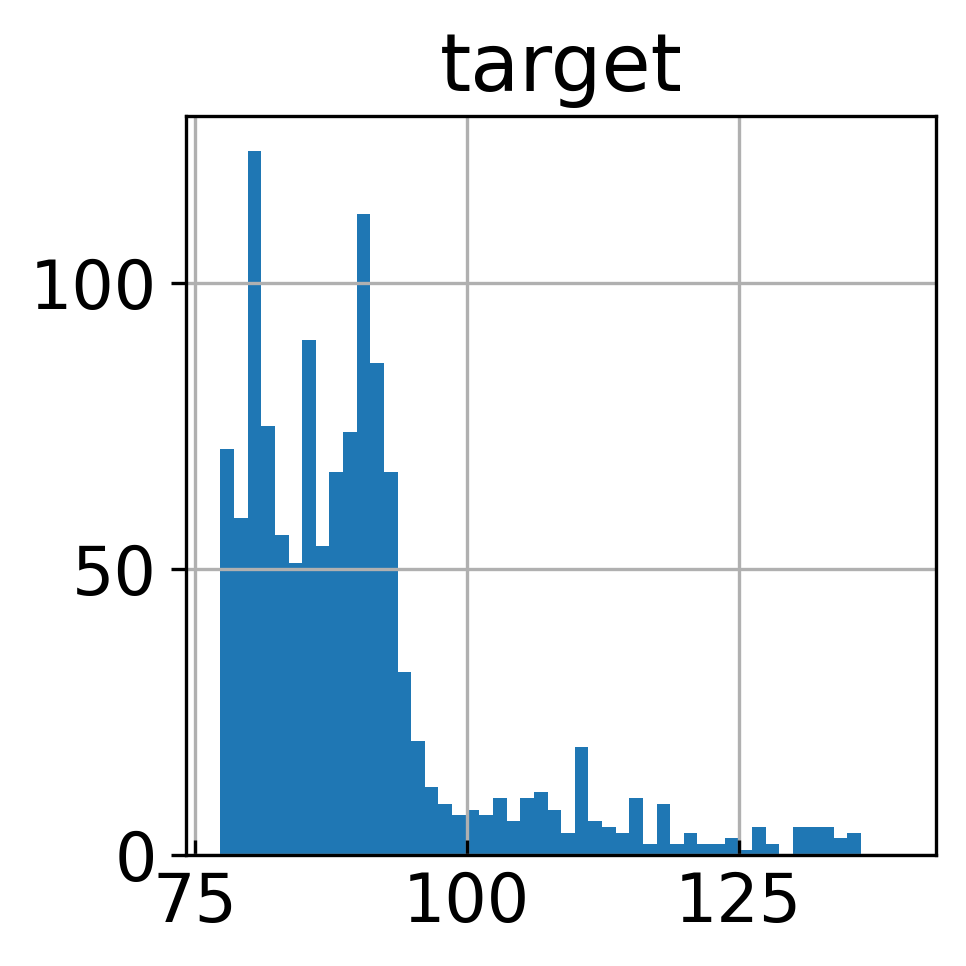

In [ ]:
#Histogram of train_df with critical temperatures above 77.36 which is the range for high-temperature superconductors

hist = train_df.hist(column='target', bins=50, range=[77.36,140], align='mid')

There are 335 predicted high-temp superconductors with a critical temperatures above 77.36 K


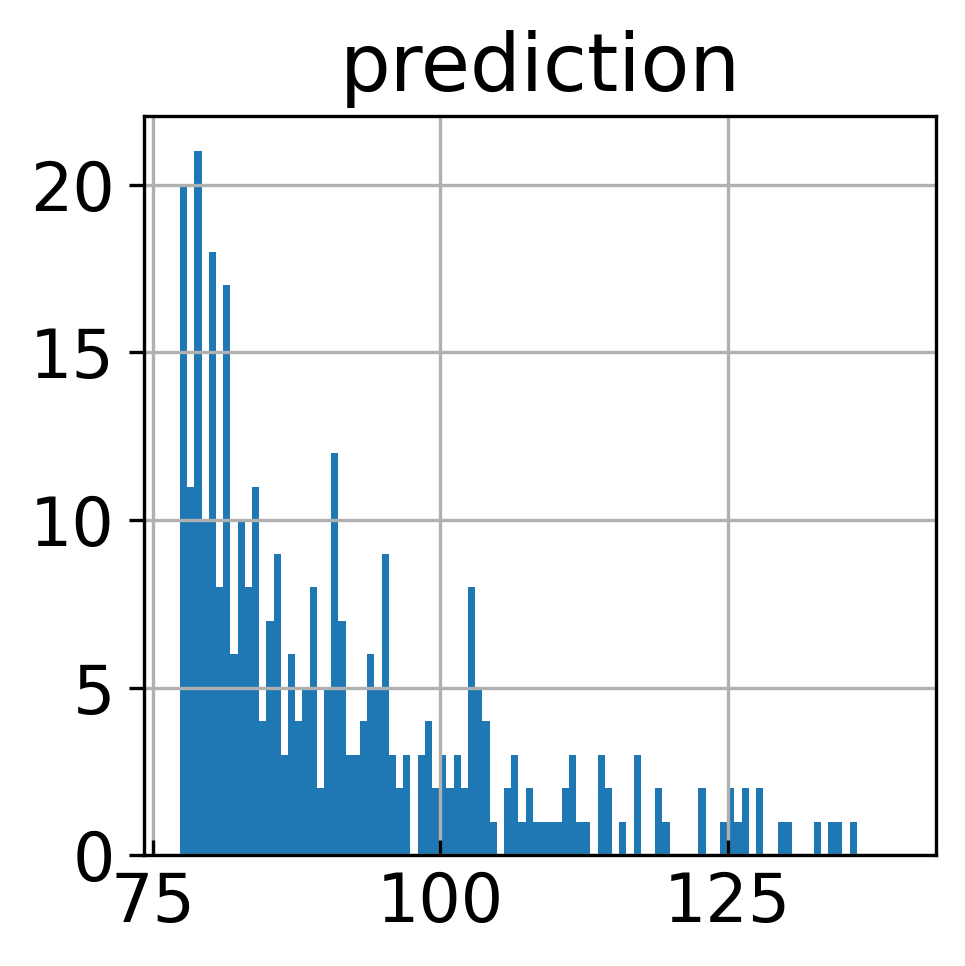

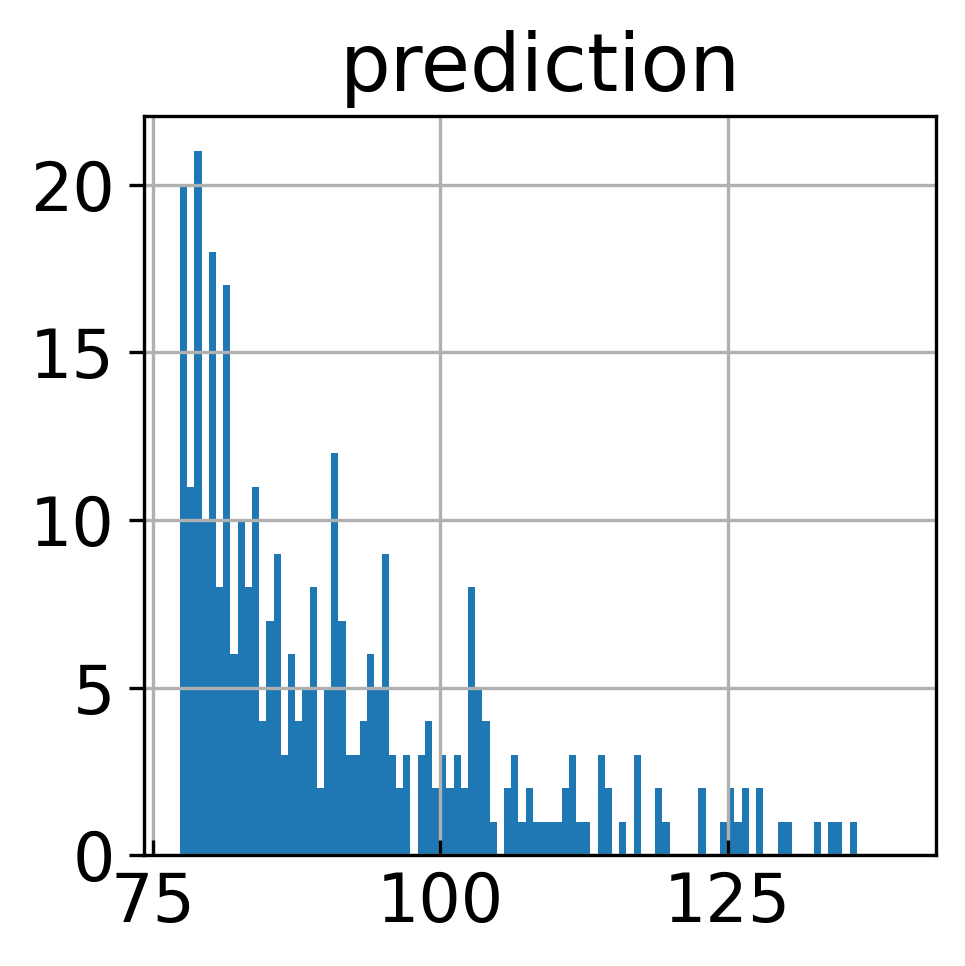

In [ ]:
#histograms for predictions

dens_hist = dens_score_df.hist(column='prediction', bins=100 ,align='mid', range= [77.36,140])

peak_hist = peak_score_df.hist(column='prediction', bins=100 ,align='mid', range= [77.36,140])

print(f"There are {(peak_score_df['prediction'] >= 77.36).sum()} predicted high-temp superconductors with a critical temperatures above 77.36 K")